In [47]:
import pandas as pd
import sqlite3
import networkx as nx
import random
import matplotlib.pyplot as plt
from pydantic import BaseModel
from collections import defaultdict
import math


In [48]:
# -------------------------------------------------------------------------------------------
# Configuration and Constants
# -------------------------------------------------------------------------------------------
TICKS_PER_DAY = 288  # 5-minute intervals per day
NUM_DAYS = 120        # Number of days to simulate
INFORMATION_PROB = 0.1  # Probability that an agent will share information with another agent

# Epidemic transmission parameters
ALPHA = 0.1  # Transmission rate from Susceptible to Exposed
BETA = 0.4   # Probability that Exposed becomes asymptomatic Infected
GAMMA = 0.3  # Probability that asymptomatic Infected becomes seriously Infected
THETA = 0.4  # Probability that seriously Infected becomes critically Infected
PHI = 0.1    # Death rate for Critically-Infected individuals
OMEGA = 0.1  # Immune rate for Recovered individuals

# Time periods individuals must stay in each state (in days)
TIME_PERIODS = {
    'E': 5,    # Exposed
    'IA': 5,   # Asymptomatic Infected
    'IS': 5,   # Seriously Infected
    'IC': 5,   # Critically Infected
    'R': 5     # Recovered
}

# Agent states
STATES = {
    'S': 'Susceptible',
    'E': 'Exposed',
    'IA': 'Asymptomatic Infected',
    'IS': 'Seriously Infected',
    'IC': 'Critically Infected',
    'R': 'Recovered',
    'M': 'Immune',
    'D': 'Dead'
}

# Behavior effect multipliers
BEHAVIORS = {
    'wearings_mask': 0.1,
    'maintaining_social_distance': 0.3,
    'self_isolating': 0
}

# Mean contact values for each location type
mean_contact_values = {
    'Home': 1,
    'Bus': 5,
    'Workplace': 3,
    'Market': 4,
    'School': 2,
    'Terminal': 3
}


In [49]:
# -------------------------------------------------------------------------------------------
# Data Models
# -------------------------------------------------------------------------------------------
class Memory(BaseModel):
    description: str
    day: int
    importance: int

class Behavior(BaseModel):
    wearing_mask: bool
    maintaining_social_distance: bool
    self_isolating: bool
        
class Belief(BaseModel):
    description: str
    sentiment: str
        
class Beliefs(BaseModel):
    beliefs: list[Belief]
    
class News(BaseModel):
    headline: str

In [50]:

# -------------------------------------------------------------------------------------------
# Stub functions for future LLM integration (currently no-ops)
# -------------------------------------------------------------------------------------------
def generate_beliefs(memories: list[Memory]):
    # Stub: return empty list of beliefs
    return []

def generate_behavior(beliefs: list[Belief]):
    # Stub: return a default behavior
    return Behavior(wearing_mask=False, maintaining_social_distance=False, self_isolating=False)

def generate_news(information: str):
    # Stub: return a simple placeholder headline
    return "No new updates"

In [51]:
# -------------------------------------------------------------------------------------------
# Agent Class
# -------------------------------------------------------------------------------------------
class Agent:
    def __init__(self, agent_id, age, gender, home, destination, destination_type, routine, network_neighbors, persona):
        self.agent_id = agent_id
        self.age = age
        self.gender = gender
        self.home = home
        self.destination = destination
        self.destination_type = destination_type
        self.routine = routine
        self.network_neighbors = network_neighbors
        self.persona = persona
        
        self.state = 'S'
        self.days_in_state = 0
        self.memories = []
        self.behavior = Behavior(wearing_mask=False, maintaining_social_distance=False, self_isolating=False)
        self.beliefs = []
        self.exposure = 0
        
        self.locations = [None] * TICKS_PER_DAY
        self.calculate_location()
        
        self.daily_interactions = []
        self.received_information = []
        
    def __repr__(self):
        return f"Agent {self.agent_id} ({self.persona})"
        
    def __str__(self):
        return f"Agent {self.agent_id} ({self.persona})"
    
    def calculate_location(self):
        for tick in range(TICKS_PER_DAY):
            location_id = self.routine[tick]
            # Determine the type of location
            if location_id == self.home:
                self.locations[tick] = (location_id, 'Home')
            elif location_id == self.destination:
                self.locations[tick] = (location_id, self.destination_type)
            else:
                # Assume any other location_id in routine is a Bus or intermediate location
                self.locations[tick] = (location_id, 'Bus')
        
    def get_location(self, current_tick):
        if self.state == 'D':
            # Dead agents are not moving
            return None, 'Dead'
        if self.behavior.self_isolating:
            # If self-isolating, agent stays at home
            return self.home, 'Home'
        else:
            return self.locations[current_tick]
        
    def interact(self, agent, current_tick):
        # Only proceed if neither agent is dead
        if self.state == 'D' or agent.state == 'D':
            return
        # Record interaction
        interaction = {
            'agent_id': agent.agent_id,
            'wearing_mask': agent.behavior.wearing_mask,
            'maintaining_social_distance': agent.behavior.maintaining_social_distance,
            'self_isolating': agent.behavior.self_isolating,
            'state': agent.state
        }
        self.daily_interactions.append(interaction)
        
        infectious_states = ['E', 'IA', 'IS', 'IC']
        
        def exposure_increase(agent1, agent2, tick):
            exposure_score = 1
            if agent1.behavior.wearing_mask:
                exposure_score *= BEHAVIORS['wearings_mask']
            if agent1.behavior.maintaining_social_distance:
                exposure_score *= BEHAVIORS['maintaining_social_distance']
            if agent1.behavior.self_isolating:
                exposure_score *= BEHAVIORS['self_isolating']
            if agent2.behavior.wearing_mask:
                exposure_score *= BEHAVIORS['wearings_mask']
            if agent2.behavior.maintaining_social_distance:
                exposure_score *= BEHAVIORS['maintaining_social_distance']
            if agent2.behavior.self_isolating:
                exposure_score *= BEHAVIORS['self_isolating']
            location_type = agent1.get_location(tick)[1]
            exposure_score *= mean_contact_values.get(location_type, 1)
            return exposure_score
        
        # Transmission conditions
        if self.state in infectious_states and agent.state == 'S':
            agent.exposure += exposure_increase(self, agent, current_tick)
        elif agent.state in infectious_states and self.state == 'S':
            self.exposure += exposure_increase(agent, self, current_tick)
        
    def update_state(self):
        if self.state == 'S':
            probability = ALPHA * math.log(self.exposure/288) if self.exposure > 0 else 0
            if random.random() < probability:
                self.state = 'E'
                self.days_in_state = 0
        elif self.state == 'E':
            if self.days_in_state >= TIME_PERIODS['E']:
                if random.random() < BETA:
                    self.state = 'IA'  # Exposed -> Asymptomatic Infected
                else:
                    self.state = 'IS'  # Exposed -> Seriously Infected
                self.days_in_state = 0
        elif self.state == 'IA':
            if self.days_in_state >= TIME_PERIODS['IA']:
                if random.random() < GAMMA:
                    self.state = 'IS'  # Asymptomatic Infected -> Seriously Infected
                else:
                    self.state = 'R'   # Asymptomatic Infected -> Recovered
                self.days_in_state = 0
        elif self.state == 'IS':
            if self.days_in_state >= TIME_PERIODS['IS']:
                if random.random() < THETA:
                    self.state = 'IC'  # Seriously Infected -> Critically Infected
                else:
                    self.state = 'R'   # Seriously Infected -> Recovered
                self.days_in_state = 0
        elif self.state == 'IC':
            if self.days_in_state >= TIME_PERIODS['IC']:
                if random.random() < PHI:
                    self.state = 'D'   # Critically Infected -> Deceased
                else:
                    self.state = 'R'   # Critically Infected -> Recovered
                self.days_in_state = 0
        elif self.state == 'R':
            if self.days_in_state >= TIME_PERIODS['R']:
                if random.random() < OMEGA:
                    self.state = 'M'   # Recovered -> Immune
                else:
                    self.state = 'S'   # Recovered -> Susceptible
                self.days_in_state = 0

        self.exposure = 0
        self.days_in_state += 1
        
    def summarize_observations(self, day):
        # Summarize today's interactions
        total_interactions = len(self.daily_interactions)
        mask_wearers = sum(1 for interaction in self.daily_interactions if interaction['wearing_mask'])
        social_distancers = sum(1 for interaction in self.daily_interactions if interaction['maintaining_social_distance'])
        self_isolators = sum(1 for interaction in self.daily_interactions if interaction['self_isolating'])
        
        description = (f"On day {day+1}, I interacted with {total_interactions} people. "
                       f"{mask_wearers} were wearing masks, {social_distancers} were maintaining social distance, "
                       f"and {self_isolators} were self-isolating.")
        importance = 5
        self.memorize(description, day, importance)
        # Clear daily interactions for the next day
        self.daily_interactions = []
        
    def receive_information(self, information, day):
        description = f"On day {day+1}, I heard that {information}"
        importance = 5
        self.memorize(description, day, importance)
        # Probability to pass info on next day
        pass_probability = 0.5
        if random.random() < pass_probability:
            self.received_information.append((information, day))
        
    def memorize(self, description, day, importance):
        memory = Memory(description=description, day=day, importance=importance)
        self.memories.append(memory)
        
    def reflect(self, day):
        # Reflection currently disabled
        # recent_memories = [memory for memory in self.memories if memory.day >= day - 1]
        # if recent_memories:
        #     self.beliefs = generate_beliefs(recent_memories)
        pass
        
    def plan(self):
        # Behavior planning currently disabled
        # if self.beliefs:
        #     self.behavior = generate_behavior(self.beliefs)
        pass

In [52]:
# -------------------------------------------------------------------------------------------
# Helper Functions
# -------------------------------------------------------------------------------------------
def get_agents_db():
    conn = sqlite3.connect("agents.db")
    pd_agents = pd.read_sql_query("SELECT * FROM agents", conn)
    conn.close()
    return pd_agents.to_dict(orient='records')

def get_network_neighbors_db(agent_id):
    conn = sqlite3.connect("agents.db")
    cur = conn.cursor()
    cur.execute("SELECT agent2 FROM network WHERE agent1 = ?", (agent_id,))
    neighbors = [row[0] for row in cur.fetchall()]
    conn.close()
    return neighbors

def get_overall_stats(agents: list[Agent]):
    num_susceptible = sum(1 for agent in agents if agent.state == 'S')
    num_exposed = sum(1 for agent in agents if agent.state == 'E')
    num_asymptomatic = sum(1 for agent in agents if agent.state == 'IA')
    num_seriously_infected = sum(1 for agent in agents if agent.state == 'IS')
    num_critically_infected = sum(1 for agent in agents if agent.state == 'IC')
    num_recovered = sum(1 for agent in agents if agent.state == 'R')
    num_immune = sum(1 for agent in agents if agent.state == 'M')
    num_dead = sum(1 for agent in agents if agent.state == 'D')
    return {
        'Susceptible': num_susceptible,
        'Exposed': num_exposed,
        'Asymptomatic': num_asymptomatic,
        'Seriously Infected': num_seriously_infected,
        'Critically Infected': num_critically_infected,
        'Recovered': num_recovered,
        'Immune': num_immune,
        'Dead': num_dead
    }

In [53]:
# -------------------------------------------------------------------------------------------
# Constructing the Network
# -------------------------------------------------------------------------------------------
conn = sqlite3.connect("agents.db")
pd_agents = pd.read_sql_query("SELECT * FROM agents", conn)
conn.close()
agents_raw = pd_agents.to_dict(orient='records')

G = nx.Graph()

# Add nodes for each agent
for agent in agents_raw:
    G.add_node(agent['agent_id'])

# Group by home and workplace to add strong ties
home_groups = {}
workplace_groups = {}

for agent in agents_raw:
    home_id = agent['home']
    if home_id not in home_groups:
        home_groups[home_id] = []
    home_groups[home_id].append(agent['agent_id'])
    
    # Only add workplace if destination_type is Workplace
    if agent['destination_type'] == "Workplace":
        workplace_id = agent['destination']
        if workplace_id not in workplace_groups:
            workplace_groups[workplace_id] = []
        workplace_groups[workplace_id].append(agent['agent_id'])

# Create strong ties (home)
for home_id, members in home_groups.items():
    if len(members) > 1:
        for i in range(len(members)):
            for j in range(i + 1, len(members)):
                G.add_edge(members[i], members[j])

# Create strong ties (workplace)
for workplace_id, members in workplace_groups.items():
    if len(members) > 1:
        for i in range(len(members)):
            for j in range(i + 1, len(members)):
                G.add_edge(members[i], members[j])

# Add random weak ties (friends)
num_agents = len(agents_raw)
agent_ids = [a['agent_id'] for a in agents_raw]
random_friend_connections = 3000
for _ in range(random_friend_connections):
    agent1 = random.choice(agent_ids)
    agent2 = random.choice(agent_ids)
    if agent1 != agent2 and not G.has_edge(agent1, agent2):
        G.add_edge(agent1, agent2)

# Write the network to DB
conn = sqlite3.connect("agents.db")
cur = conn.cursor()
cur.execute("CREATE TABLE IF NOT EXISTS network (agent1 INT, agent2 INT)")
cur.execute("DELETE FROM network")  # Clear previous data
for edge in G.edges():
    cur.execute("INSERT INTO network (agent1, agent2) VALUES (?, ?)", (edge[0], edge[1]))
    cur.execute("INSERT INTO network (agent1, agent2) VALUES (?, ?)", (edge[1], edge[0]))
conn.commit()
conn.close()

In [54]:
# -------------------------------------------------------------------------------------------
# Load Agents into Simulation
# -------------------------------------------------------------------------------------------
agents_db = get_agents_db()
agents = []
for agent_db in agents_db:
    routine = agent_db['routine'].split(',')
    neighbors = get_network_neighbors_db(agent_db['agent_id'])
    persona = (
        f"He/She is a {agent_db['age']} year old {agent_db['gender']} who goes to {agent_db['destination_type']} everyday. "
        f"He/She has following personality: Openness: {agent_db['personality_openness']}, Conscientiousness: {agent_db['personality_conscientiousness']}, "
        f"Extraversion: {agent_db['personality_extraversion']}, Agreeableness: {agent_db['personality_agreeableness']}, Neuroticism: {agent_db['personality_neuroticism']}. "
        f"He/She has following demographic: Education: {agent_db['demographic_education']}, Income Level: {agent_db['demographic_income_level']}. "
        f"He/She has following health: Immune System Strength: {agent_db['health_immune_system_strength']}, Pre-existing Conditions: {agent_db['health_pre_existing_conditions']}. "
        f"He/She has following psychographic: Risk Attitude: {agent_db['psychographic_risk_attitude']}, Belief System: {agent_db['psychographic_belief_system']}, "
        f"Information Sensitivity: {agent_db['psychographic_information_sensitivity']}, Fear Level: {agent_db['psychographic_fear_level']}. "
        f"He/She has following behavior: Routine: {agent_db['behavior_routine']}, Compliance Level: {agent_db['behavior_compliance_level']}."
    )
    agent = Agent(
        agent_id=agent_db['agent_id'],
        age=agent_db['age'],
        gender=agent_db['gender'],
        home=agent_db['home'],
        destination=agent_db['destination'],
        destination_type=agent_db['destination_type'],
        routine=routine,
        network_neighbors=neighbors,
        persona=persona
    )
    agents.append(agent)

# Initialize some agents as infected
initial_infected = random.sample(agents, k=10)
for agent in initial_infected:
    agent.state = 'E'
    agent.days_in_state = 0

stats_records = []

In [ ]:
# -------------------------------------------------------------------------------------------
# Main Simulation Loop with Optimization
# -------------------------------------------------------------------------------------------
for day in range(NUM_DAYS):
    # Each tick, group agents by location
    for tick in range(TICKS_PER_DAY):
        locations_dict = defaultdict(list)
        
        # Group agents by current location
        for agent in agents:
            if agent.state == 'D':
                continue
            loc_id, loc_type = agent.get_location(tick)
            if loc_id is not None and loc_type != 'Dead':
                locations_dict[(loc_id, loc_type)].append(agent)
        
        # Interactions: only among agents in the same location
        for (loc_id, loc_type), agents_at_loc in locations_dict.items():
            n_agents_loc = len(agents_at_loc)
            if n_agents_loc > 1:
                for i in range(n_agents_loc):
                    for j in range(i+1, n_agents_loc):
                        agent_i = agents_at_loc[i]
                        agent_j = agents_at_loc[j]
                        # Interact both ways
                        agent_i.interact(agent_j, tick)
                        agent_j.interact(agent_i, tick)

    # End of day: Summarize observations
    for agent in agents:
        agent.summarize_observations(day)
    
    # Compute stats
    stats = get_overall_stats(agents)
    stats_records.append(stats)
    num_infected = stats['Exposed'] + stats['Asymptomatic'] + stats['Seriously Infected'] + stats['Critically Infected']

    # Generate and spread news if we have at least two days of data
    if len(stats_records) >= 2:
        previous_stats = stats_records[-2]
        previous_num_infected = previous_stats['Exposed'] + previous_stats['Asymptomatic'] + previous_stats['Seriously Infected'] + previous_stats['Critically Infected']
        
        # Placeholder news
        news = generate_news(f"Today, there were {num_infected} new infections. Total infections: {num_infected}. Previous day infections: {previous_num_infected}. Also, {stats['Dead']} people died, which changed from previous day by {stats['Dead'] - previous_stats['Dead']}.")
        
        # Spread news to random subset of agents
        num_agents_to_receive_news = int(0.1 * len(agents))
        if num_agents_to_receive_news > 0:
            agents_receiving_news = random.sample(agents, num_agents_to_receive_news)
            for agent in agents_receiving_news:
                agent.receive_information(news, day)
    
    # Agents pass information to their neighbors
    for agent in agents:
        for information, info_day in agent.received_information:
            if day - info_day > 7:
                # Forget information after 7 days
                agent.received_information.remove((information, info_day))
                continue
            # Pass the information to neighbors with some probability
            pass_probability = INFORMATION_PROB
            for neighbor_id in agent.network_neighbors:
                if random.random() < pass_probability:
                    neighbor_agent = next((a for a in agents if a.agent_id == neighbor_id), None)
                    if neighbor_agent:
                        neighbor_agent.receive_information(information, day)
        # Clear after passing it on
        agent.received_information = []
        
    # Update states
    for agent in agents:
        agent.update_state()
        
    # Reflection and planning (disabled)
    # for agent in agents:
    #     agent.reflect(day)
    #     agent.plan()
    
    # Print daily stats
    print(f"Day {day+1} stats: Susceptible: {stats['Susceptible']}, Exposed: {stats['Exposed']}, Asymptomatic: {stats['Asymptomatic']}, Seriously Infected: {stats['Seriously Infected']}, Critically Infected: {stats['Critically Infected']}, Recovered: {stats['Recovered']}, Immune: {stats['Immune']}, Dead: {stats['Dead']}")

Day 1 stats: Susceptible: 990, Exposed: 10, Asymptomatic: 0, Seriously Infected: 0, Critically Infected: 0, Recovered: 0, Immune: 0, Dead: 0
Day 2 stats: Susceptible: 984, Exposed: 16, Asymptomatic: 0, Seriously Infected: 0, Critically Infected: 0, Recovered: 0, Immune: 0, Dead: 0
Day 3 stats: Susceptible: 976, Exposed: 24, Asymptomatic: 0, Seriously Infected: 0, Critically Infected: 0, Recovered: 0, Immune: 0, Dead: 0
Day 4 stats: Susceptible: 940, Exposed: 60, Asymptomatic: 0, Seriously Infected: 0, Critically Infected: 0, Recovered: 0, Immune: 0, Dead: 0
Day 5 stats: Susceptible: 870, Exposed: 130, Asymptomatic: 0, Seriously Infected: 0, Critically Infected: 0, Recovered: 0, Immune: 0, Dead: 0
Day 6 stats: Susceptible: 771, Exposed: 229, Asymptomatic: 0, Seriously Infected: 0, Critically Infected: 0, Recovered: 0, Immune: 0, Dead: 0
Day 7 stats: Susceptible: 640, Exposed: 344, Asymptomatic: 8, Seriously Infected: 8, Critically Infected: 0, Recovered: 0, Immune: 0, Dead: 0
Day 8 stat

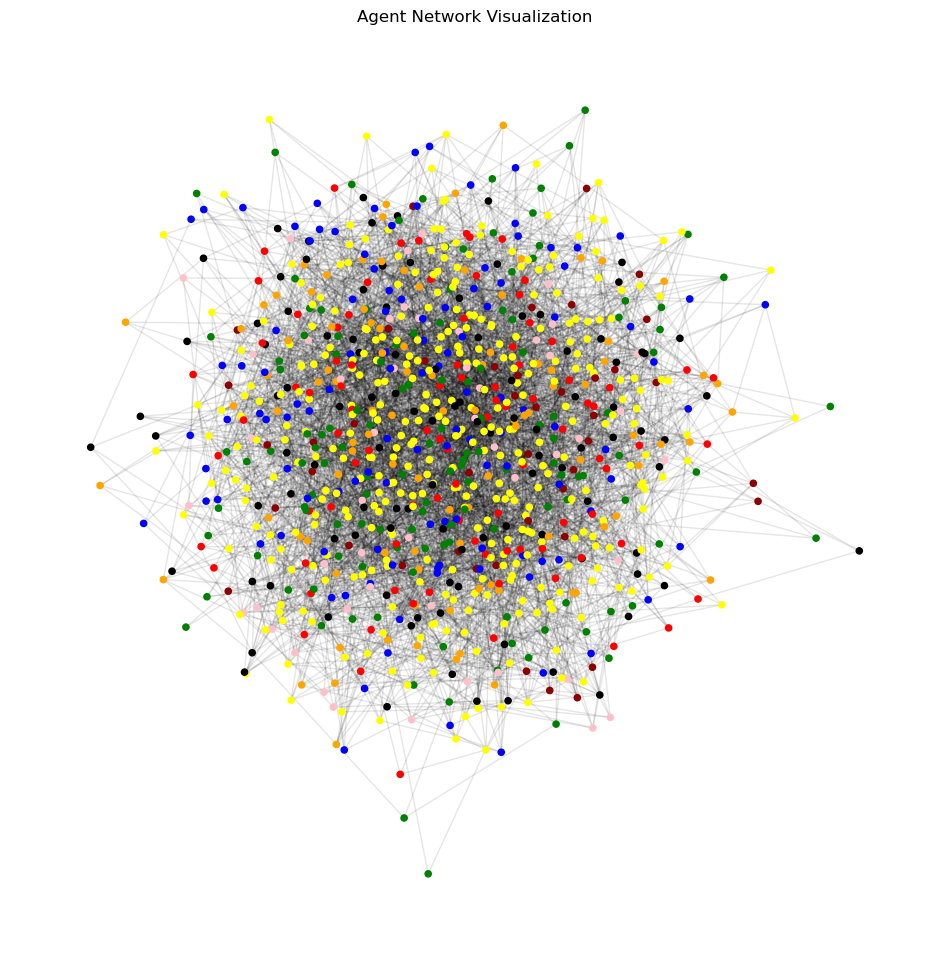

In [56]:
# -------------------------------------------------------------------------------------------
# Final Visualization
# -------------------------------------------------------------------------------------------
G_final = nx.Graph()
for agent in agents:
    G_final.add_node(agent.agent_id, state=agent.state)

for agent in agents:
    for neighbor_id in agent.network_neighbors:
        G_final.add_edge(agent.agent_id, neighbor_id)

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G_final, seed=42)
node_colors = []
for agent in agents:
    if agent.state == 'S':
        node_colors.append('green')
    elif agent.state == 'E':
        node_colors.append('orange')
    elif agent.state == 'IA':
        node_colors.append('pink')
    elif agent.state == 'IS':
        node_colors.append('red')
    elif agent.state == 'IC':
        node_colors.append('darkred')
    elif agent.state == 'R':
        node_colors.append('blue')
    elif agent.state == 'M':
        node_colors.append('yellow')
    elif agent.state == 'D':
        node_colors.append('black')

nx.draw_networkx_nodes(G_final, pos, node_size=20, node_color=node_colors)
nx.draw_networkx_edges(G_final, pos, alpha=0.1)
plt.title("Agent Network Visualization")
plt.axis('off')
plt.show()